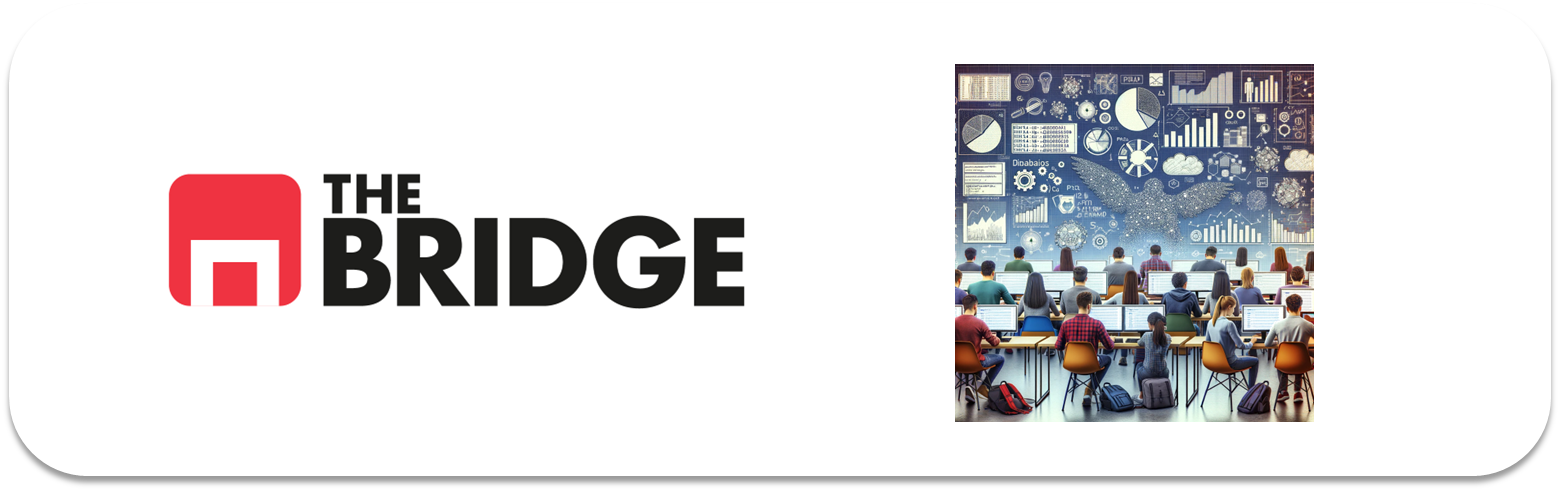

## PRACTICA OBLIGATORIA: **Clasificacion y Regresion Logistica**

* La práctica obligatoria de esta unidad consiste en modelar la supervivencia en el Titanic, por fin, además de una parte adicional multiclase. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [59]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
%matplotlib inline

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, balanced_accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay


### Indicaciones

A continuación tienes las indicaciones para hacer el modelado. No necesariamente tienes que seguirlos al pie de la letra, porque a partir de ahora ya las práctica obligatorias dejarán de ser mayormente guiadas por ejercicios y serán más de libre desarrollo, aunque con objetivos específicos, claros y determinados. 

En concreto se pide hacer un modelo de regresión logística, evaluarlo contra un dataset de test reservado del original mostrando las métricas propias de los problemas de clasificación, la matriz de confusión y la curva ROC. Además se pide comparar las predicciones con los valores reales y al final adaptar el modelo a un problema multiclase.

Los pasos para guiar el trabajo:
1. Carga el dataset del Titanic. 
2. Deshazte de las variables que no vayas a usar. Limpia lo que creas necesarios pero no hagas imputaciones.
3. Escoge y analiza la variable target de forma gráfica y razona sobre el impacto de la distribución en los resultados esperados. Ten en cuenta que lo que queremos es poder predecir si un pasajero sobrevivirá.
4. Haz el split en train y test que creas conveniente pero asegurándote que ambos conjuntos tienen un reparto similar de pasajeros embarcados en las tres ciudades.
5. Construye las parejas X,y de train y test.
6. Ahora sí imputa los nulos con medias y modas en la X de train. Guarda esas medias que necesitarás en la parte de test.
7. Haz un mini-EDA, selecciona las features que quieres quedarte y por qué.
8. Trata las variables para que funcionen lo mejor posible en el modelo.
9. Construye un modelo de regresión logística.
10. EXTRA: Analiza si lo crees conveniente los pesos y la importancia de las features.
11. Procesa el dataset de Test para que puedas usarlo en la evaluación 
12. Evalúa tu modelo contra el dataset de test y train. Obten las matrices de confusión y las métricas que creas adecuadas. Haz un pequeño assesment de su generabilidad.
13. EXTRA: Halla la probabilidad de supervivencia de un hombre de entre 30 y 40 años, que embarcó en Southampton en segunda clase, viajaba solo y no pagó el billete. PISTA: En este caso tendrás que calcular varias probabilidades y hacer la media de ellas.
14. EXTRA: Aprovecha todo el trabajo haciendo un único cambio en el target, ahora será la clase del viajero. Cambia el target quitándolo de X_train, X_test y añade a estos el target anterior. El resto no deberías cambiarlo. Entrena y evalua el modelo sólo con el classification_report.  



Carga de datos y primer vistazo

In [60]:
titanic = pd.read_csv("./data/titanic.csv")

In [61]:
titanic.columns

Index(['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare',
       'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town',
       'alive', 'alone'],
      dtype='object')

In [62]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     891 non-null    int64  
 1   pclass       891 non-null    int64  
 2   sex          891 non-null    object 
 3   age          714 non-null    float64
 4   sibsp        891 non-null    int64  
 5   parch        891 non-null    int64  
 6   fare         891 non-null    float64
 7   embarked     889 non-null    object 
 8   class        891 non-null    object 
 9   who          891 non-null    object 
 10  adult_male   891 non-null    bool   
 11  deck         203 non-null    object 
 12  embark_town  889 non-null    object 
 13  alive        891 non-null    object 
 14  alone        891 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(7)
memory usage: 92.4+ KB


In [63]:
titanic.describe()

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Limpieza de datos

In [64]:
titanic.drop(["survived", "pclass", "sex", "parch", "adult_male", "deck", "embark_town", "fare"], axis = 1, inplace = True)
# Quito todas estas que de alguna forma replican otras columnas

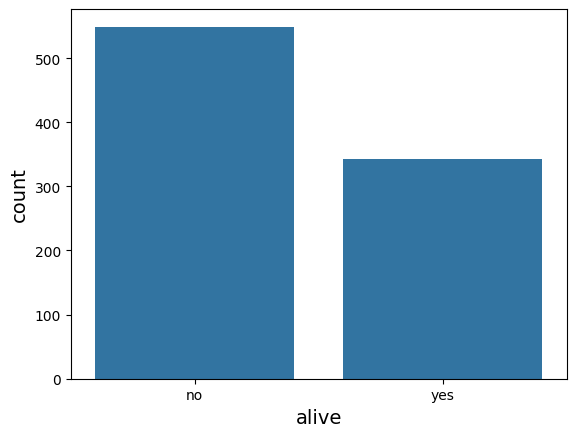

In [65]:
sns.countplot(x = "alive", data = titanic);

La distribición es desigual, pero tampoco demasiado desproporcionadamente. En cualquier caso, hay que tener en cuenta que hay una mayor frecuencia de no que de yes

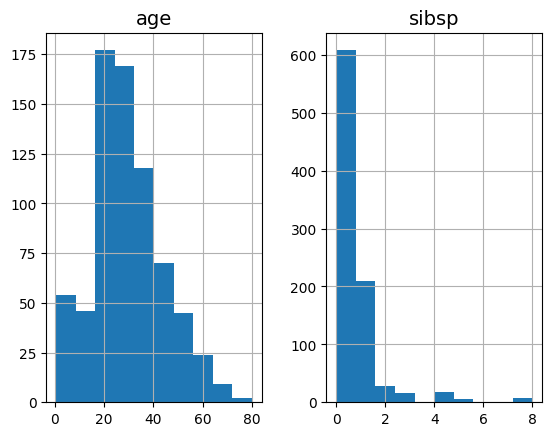

In [66]:
titanic.hist();

Preparación de 2 sets estratificados

In [67]:
titanic = titanic.loc[titanic['embarked'].notna()]

In [68]:
X = titanic.drop(['alive'], axis=1)
y = titanic['alive']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, stratify= titanic["embarked"], random_state=42) 

In [69]:
X_train["embarked"].value_counts(normalize = True)

embarked
S    0.724332
C    0.188467
Q    0.087201
Name: proportion, dtype: float64

In [70]:
X_test["embarked"].value_counts(normalize = True)

embarked
S    0.724719
C    0.191011
Q    0.084270
Name: proportion, dtype: float64

Tratamiento de nulos

In [71]:
media_edad = round(X_train['age'].mean())
X_train['age'] = X_train['age'].fillna(media_edad)
print(media_edad)
# En el test set habrá que imputar con este mismo valor de la media de X_train
# Hegoi ha hecho esto estratificando en hombres, mujeres y niños, y sacando la media para cada grupo, según Train
# Y dsp al tets set le ha imputado esta media a los nulos

30


In [72]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 711 entries, 46 to 253
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       711 non-null    float64
 1   sibsp     711 non-null    int64  
 2   embarked  711 non-null    object 
 3   class     711 non-null    object 
 4   who       711 non-null    object 
 5   alone     711 non-null    bool   
dtypes: bool(1), float64(1), int64(1), object(3)
memory usage: 34.0+ KB


No hay más nulos en X_train que los que había en age. No hay nada más que imputar.

Tratamiento de variables categóricas y binarias


In [73]:
#pd.get_dummies(X_train, columns=["embarked"]).head()

In [74]:
#pd.get_dummies(X_train, columns=["embarked"], dtype= int).head()

In [75]:
#train_bck = X_train.copy()
#X_train = pd.get_dummies(X_train, columns = ["embarked"], dtype = int)

In [76]:
#X_train.rename(columns = {'embarked_C': 'Cherbourg', "embarked_Q": "Queenstown", "embarked_S": "Southampton"}, inplace=True)

In [77]:
#pd.get_dummies(X_train, columns=["class"]).head()

In [78]:
#pd.get_dummies(X_train, columns=["class"], dtype= int).head()

In [79]:
#train_bck = X_train.copy()
#X_train = pd.get_dummies(X_train, columns = ["class"], dtype = int)

In [80]:
#X_train.rename(columns = {'class_First': 'First_cl', "class_Second": "Second_cl", "class_Third": "Third_cl"}, inplace=True)

In [81]:
#pd.get_dummies(X_train, columns=["who"]).head()

In [82]:
#pd.get_dummies(X_train, columns=["who"], dtype= int).head()

In [83]:
#train_bck = X_train.copy()
#X_train = pd.get_dummies(X_train, columns = ["who"], dtype = int)

In [84]:
#X_train.rename(columns = {'who_child': 'child', "who_man": "man", "who_woman": "woman"}, inplace=True)

In [85]:
X_train['embarked'] = X_train['embarked'].replace({'S': 1, 'C': 2, 'Q': 3})

C:\Users\marce\AppData\Local\Temp\ipykernel_39556\3813239793.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train['embarked'] = X_train['embarked'].replace({'S': 1, 'C': 2, 'Q': 3})


In [86]:
X_train['who'] = X_train['who'].replace({'man': 1, 'woman': 2, 'child': 3})

C:\Users\marce\AppData\Local\Temp\ipykernel_39556\1992471651.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train['who'] = X_train['who'].replace({'man': 1, 'woman': 2, 'child': 3})


In [87]:
X_train['class'] = X_train['class'].replace({'First': 1, 'Second': 2, 'Third': 3})

C:\Users\marce\AppData\Local\Temp\ipykernel_39556\2214795007.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train['class'] = X_train['class'].replace({'First': 1, 'Second': 2, 'Third': 3})


In [88]:
X_train['alone'] = X_train['alone'].astype(int)

In [89]:
y_train = y_train.replace({'yes': 1, 'no': 0})

C:\Users\marce\AppData\Local\Temp\ipykernel_39556\2607059130.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_train = y_train.replace({'yes': 1, 'no': 0})


In [90]:
X_train.head(10)

,age,sibsp,embarked,class,who,alone
46,30.0,1,3,3,1,0
230,35.0,1,1,1,2,0
657,32.0,1,3,3,2,0
888,30.0,1,1,3,2,0
809,33.0,1,1,1,2,0
679,36.0,0,2,1,1,0
64,30.0,0,2,1,1,1
71,16.0,5,1,3,2,0
299,50.0,0,2,1,2,0
824,2.0,4,1,3,3,0


In [91]:
# Y le tendré que hacer las mismas transformaciones al test
X_test['embarked'] = X_test['embarked'].replace({'S': 1, 'C': 2, 'Q': 3})

C:\Users\marce\AppData\Local\Temp\ipykernel_39556\971469345.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_test['embarked'] = X_test['embarked'].replace({'S': 1, 'C': 2, 'Q': 3})


In [92]:
X_test['who'] = X_test['who'].replace({'man': 1, 'woman': 2, 'child': 3})

C:\Users\marce\AppData\Local\Temp\ipykernel_39556\3597325350.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_test['who'] = X_test['who'].replace({'man': 1, 'woman': 2, 'child': 3})


In [93]:
X_test['class'] = X_test['class'].replace({'First': 1, 'Second': 2, 'Third': 3})

C:\Users\marce\AppData\Local\Temp\ipykernel_39556\242710956.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_test['class'] = X_test['class'].replace({'First': 1, 'Second': 2, 'Third': 3})


In [94]:
X_test['alone'] = X_test['alone'].astype(int)

In [95]:
y_test = y_test.replace({'yes': 1, 'no': 0})

C:\Users\marce\AppData\Local\Temp\ipykernel_39556\4050976020.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_test = y_test.replace({'yes': 1, 'no': 0})


In [96]:
#despues tendré montonces de columnas más como se veía en el ejemplo:
# features = ['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
#       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
#       'ocean_proximity_NEAR OCEAN', "income_cat", "rooms_per_house","total_rooms","housing_median_age","bedrooms_ratio"]

Mini EDA

In [97]:
df_eda = X_train.copy()
df_eda["alive"] = y_train.copy()

In [98]:
np.abs(df_eda.corr()['alive']).sort_values(ascending=False)
# correlación en números absolutos

alive       1.000000
who         0.485520
class       0.333723
alone       0.200779
embarked    0.130333
age         0.047804
sibsp       0.006820
Name: alive, dtype: float64

In [99]:
corr = np.abs(df_eda.corr()['alive']).sort_values(ascending=False)
bad_corr_feat = corr[corr < 0.05].index.values
df_eda.drop(columns=bad_corr_feat, inplace=True)

# correación gráfica con la matriz quitando los de baja correlación, en este caso: sobsp, Queenstown, y, sorprendentemente, age

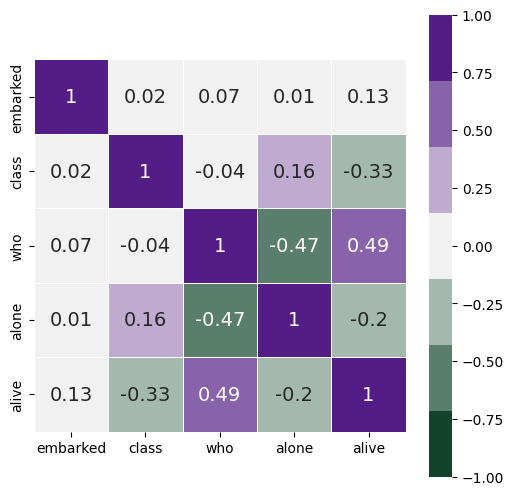

In [121]:
# el heatmap
plt.figure(figsize=(6,6))
sns.heatmap(np.round(df_eda.corr(), 2),
            vmin=-1,
            vmax=1,
            annot=True,
            cmap=sns.diverging_palette(145, 280, s=85, l=25, n=7),
            square=True,
            linewidths=.5);

In [101]:
features_tit = [col for col in df_eda.columns if "alive" not in col]
X_train = X_train[features_tit].copy()
features_tit

['embarked', 'class', 'who', 'alone']

Las variables seleccionadas corresponden a las que tienen una correlación con el target mayor a 0,05.

array([[<Axes: title={'center': 'embarked'}>,
        <Axes: title={'center': 'class'}>],
       [<Axes: title={'center': 'who'}>,
        <Axes: title={'center': 'alone'}>],
       [<Axes: title={'center': 'alive'}>, <Axes: >]], dtype=object)

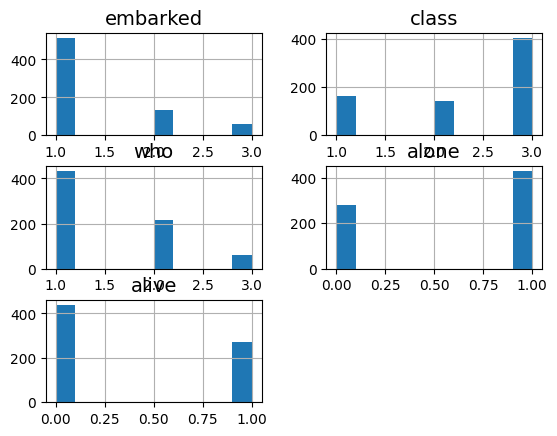

In [102]:
df_eda.hist()

Si nos olvidamos de las que eran categóricas, más las binarias, más las de baja correlación, solo nos quedan aplicarle el logaritmo a fare.

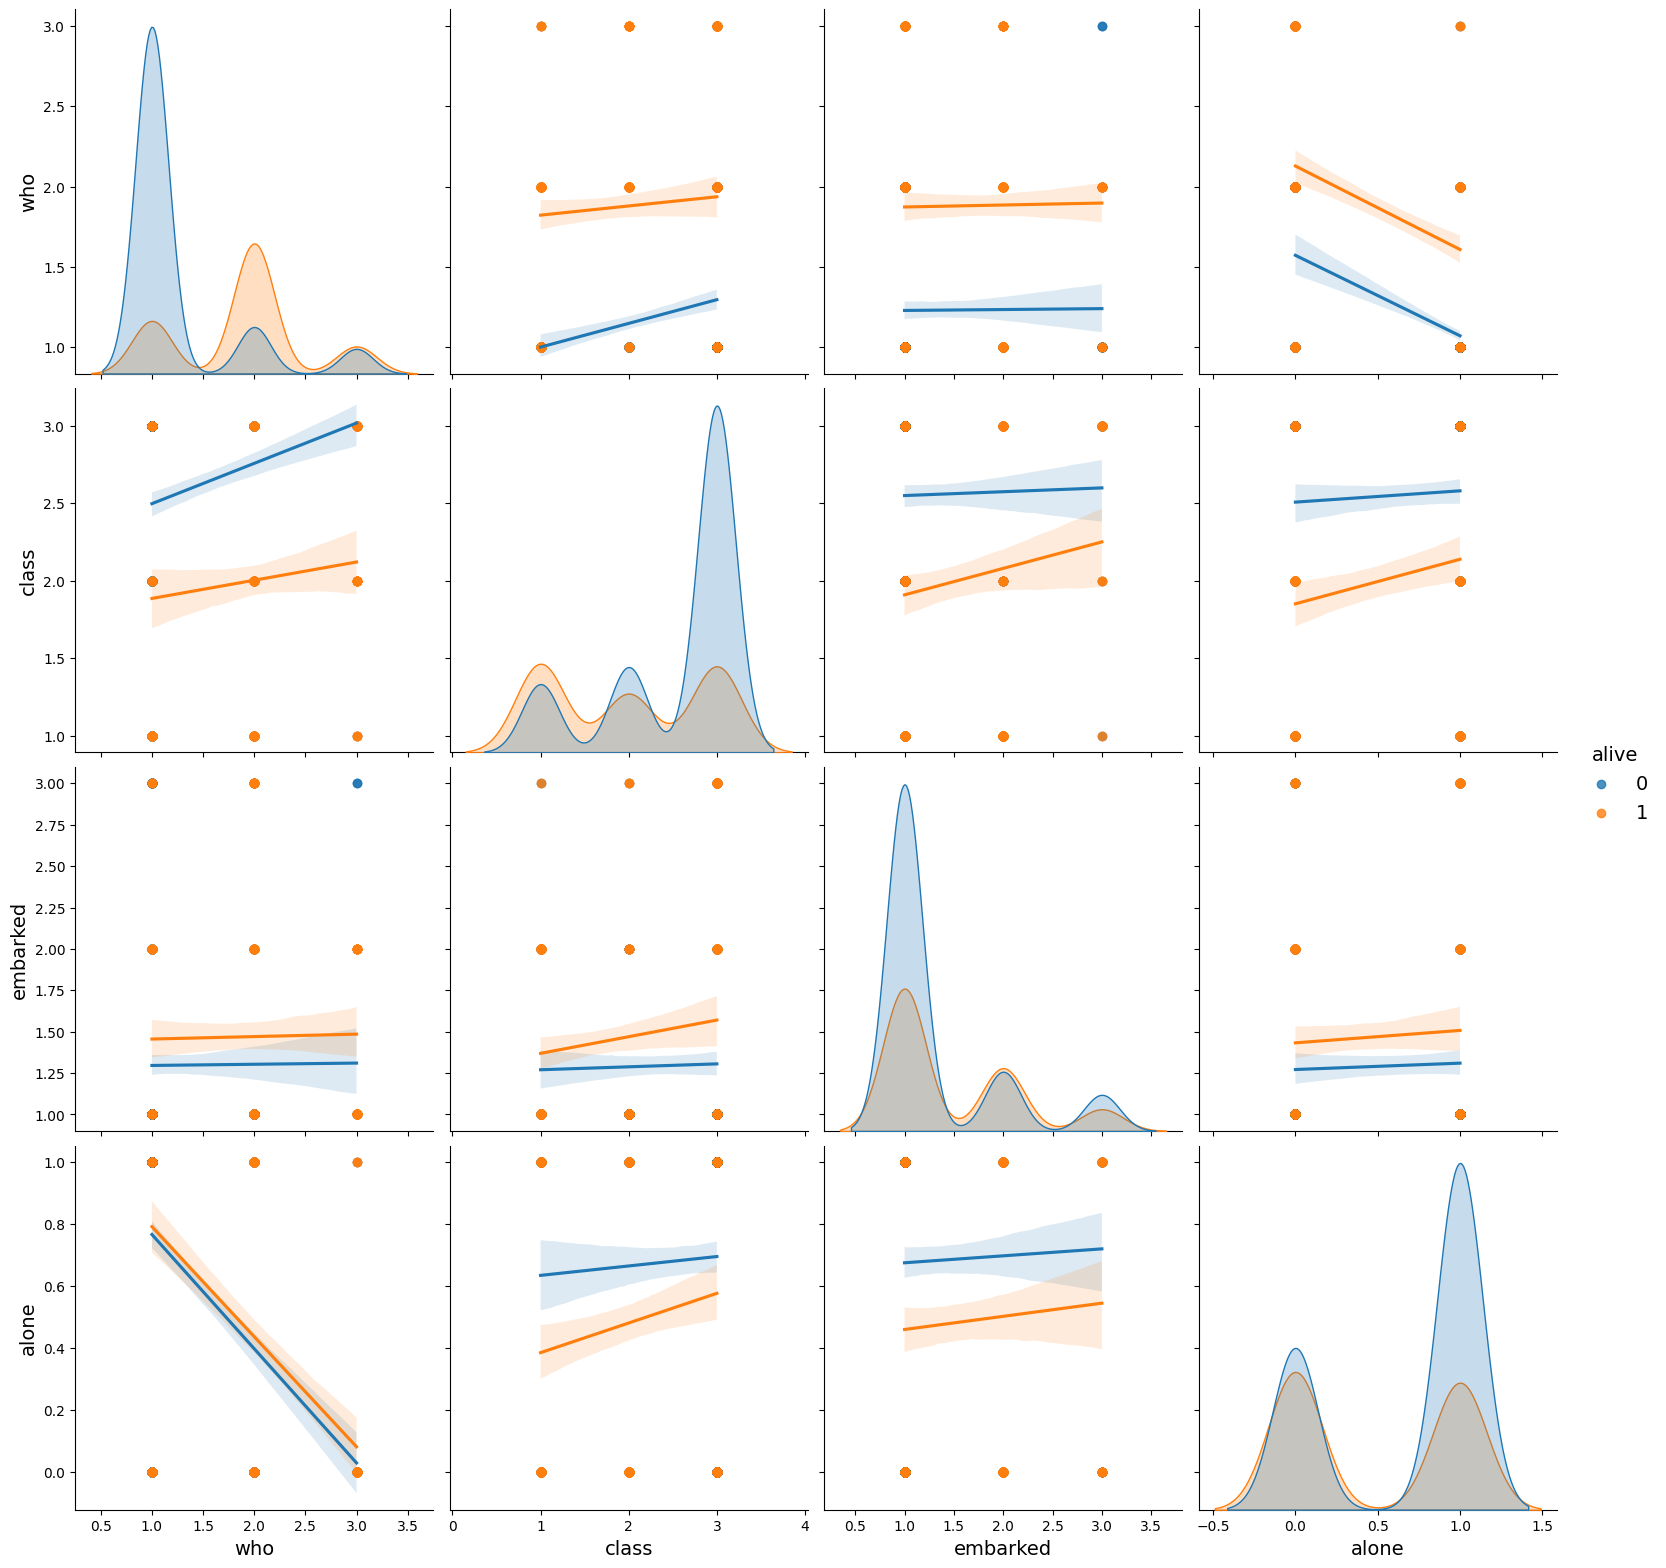

In [103]:
sns.pairplot(df_eda,
            hue='alive',
            height=4,
            vars=["who", "class", "embarked", "alone"],
            kind='reg');

Preparación de features

In [104]:
features = df_eda.drop("alive", axis = 1).columns.to_list()
print(features)

['embarked', 'class', 'who', 'alone']


In [105]:
#X_train['fare'] = X_train['fare'].apply(np.log1p)

#X_train[['fare']].hist(bins=30, figsize=(12, 5))
#plt.show()

In [106]:
#X_test['fare'] = X_test['fare'].apply(np.log1p)

Originalmente había pensado en tratar (logaritmo y standarización) fare y age. Pero age quedó descartada al no superar el 0,05 en la matriz de correlación, y "fare" quedó descartada por correlar demasiado con "class" No uso el StandardScaler ni log.

array([[<Axes: title={'center': 'embarked'}>,
        <Axes: title={'center': 'class'}>],
       [<Axes: title={'center': 'who'}>,
        <Axes: title={'center': 'alone'}>]], dtype=object)

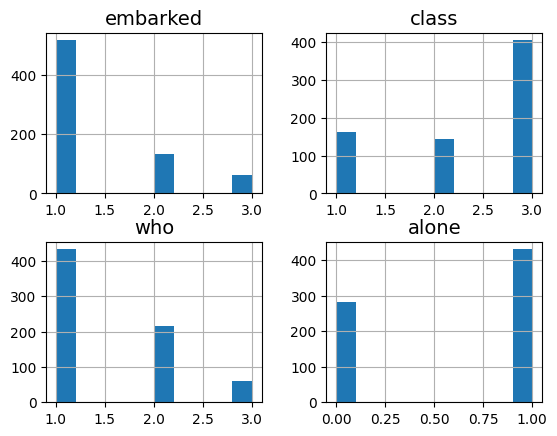

In [107]:
X_train.hist()
# Verificamos que se haya hecho bien la transformación logarítmica y el escalado

Modelado

In [108]:
log_reg = LogisticRegression(max_iter = 5000)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000)

In [109]:
print(log_reg.coef_)
print(log_reg.intercept_)
print(log_reg.classes_)

[[ 0.43930716 -1.05524105  1.93056702  0.43879123]]
[-1.90407777]
[0 1]


Pesos e importancia de las features

In [110]:
intercept = log_reg.intercept_
coefs = log_reg.coef_.ravel()

In [111]:
features = pd.DataFrame(coefs, X_train.columns, columns=['coefficient']).copy()
features['coefficient'] = np.abs(features['coefficient'])

features.sort_values('coefficient', ascending=False).head()

,coefficient
who,1.930567
class,1.055241
embarked,0.439307
alone,0.438791


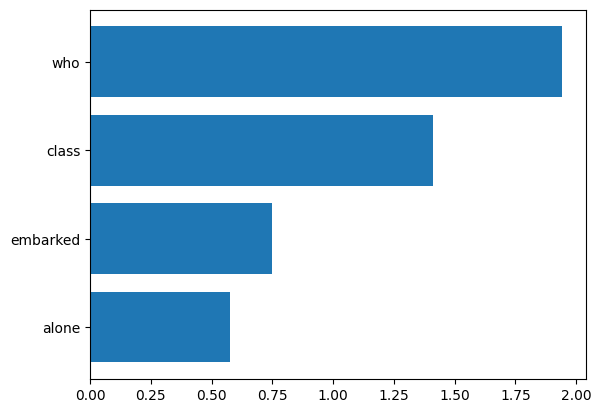

In [123]:
stdevs = []
for i in X_train.columns:
    stdev = X_train[i].std()
    stdevs.append(stdev)

features["stdev"] = np.array(stdevs).reshape(-1,1)
features["importance"] = features["coefficient"] * features["stdev"]
features['importance_standarized'] = features['importance'] / y_train.std()

features = features.sort_values('importance_standarized', ascending=True)
plt.barh(features.index, features.importance_standarized);
# Igualmente claramente hay cosas mal con este modelo, ya que los who se excluyen mutuamente, igual que class y el puerto
# cuando intentaba hacer esta parte con las categóricas transformadas con el One hot encoder, me aparecían en barras separadas woman, man, etc, como si fueran variables 
# independientes. Por esto quité el One hot encoder y he optado por remplazar los valores por 1,2 y 3.
# Pero sigo pensando que esta parte es la que debería ajustar, y debería haber dejado el One Hot encoder del inicio

Procesamiento del dataset de Test

In [113]:
X_test = X_test[X_train.columns].copy()

In [114]:
acc_train = round(accuracy_score(log_reg.predict(X_train), y_train), 3)
# hacemos accuracy score de las predicciones frente al target
acc_test = round(accuracy_score(log_reg.predict(X_test), y_test), 3)
# Y de las predicciones del test frente al test

print("Accuracy train:", acc_train)
print("Accuracy test:", acc_test)

Accuracy train: 0.805
Accuracy test: 0.775


Evalúa tu modelo contra el dataset de test y train.

In [115]:
y_train.value_counts(True)

alive
0    0.618847
1    0.381153
Name: proportion, dtype: float64

In [116]:
y_test.value_counts(True)


alive
0    0.61236
1    0.38764
Name: proportion, dtype: float64

Confusión, métricas y balance

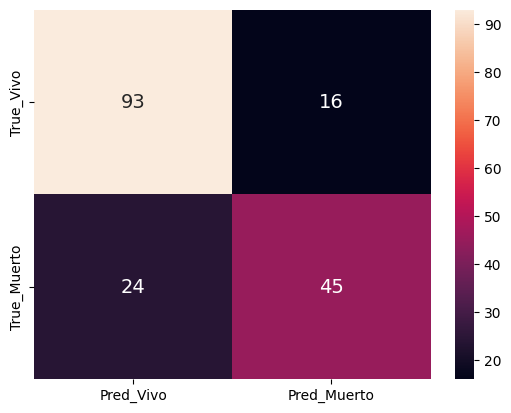

In [117]:
c_matrix = confusion_matrix(y_test, log_reg.predict(X_test))
c_matrix_df = pd.DataFrame(c_matrix, columns = ['Pred_Vivo', 'Pred_Muerto'],
                          index = ['True_Vivo', 'True_Muerto'])

sns.heatmap(c_matrix_df, annot=True, fmt='g');

c:\Users\marce\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


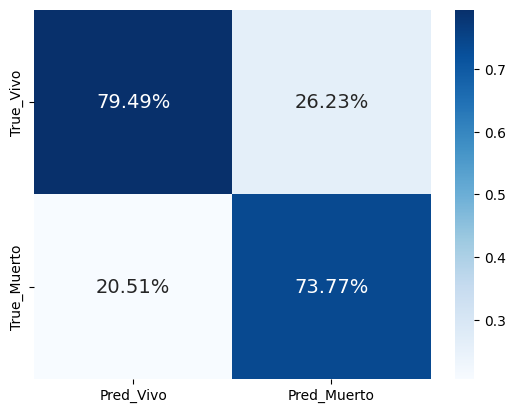

In [118]:
sns.heatmap(c_matrix_df/np.sum(c_matrix_df), annot=True, 
            fmt='.2%', cmap='Blues');
# con las cifras

In [119]:
print(classification_report(y_test, log_reg.predict(X_test)))
# informe clasificación

              precision    recall  f1-score   support

           0       0.79      0.85      0.82       109
           1       0.74      0.65      0.69        69

    accuracy                           0.78       178
   macro avg       0.77      0.75      0.76       178
weighted avg       0.77      0.78      0.77       178



con valores que no llegan al 80% (y cuando llega es con los muertos, que son los más fáciles de acertar por su elevada frecuencia, si bien los muertos no son el 80%), el modelo parece bastante pobre, en todas las instancias de evaluación

Los extra requieren trabajar con la columna fare y la columna age, ambas ya desaparecidas en mi modelo por los motivos ya expuestos... así que no es viable hacer estos ajustes ahora